# the zig zag

From the book:

We first pre-calculate the table with 
$$
C(n,p) = \sum_{k=1}^{n} s(k)s(k+p)
$$

Then we approximate the exponent by, which is to be maximised:
$$
- \sum_{k=1}^{K} \sum_{n_k - 1}^{n_k - p_k} (s(n_k+p_k)-s(n))^2
$$

which is approximated by
$$
- 2 \sum_{n=1}^{40000} s(n)^2 + 2 \sum_{k=1}^{K}(C(n_k,p_k) - C(n_{k-1},p_k))
$$

Our objective is to $\textbf{minimise}$ the summation
$$
\sum_{k=1}^{K}(C(n_{k-1},p_k) - C(n_k,p_k))
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# spliced signals
# signal = [np.sin(2*np.pi*x/4.01) for x in range(300)]

signal1 = [0.7 * np.sin(2*np.pi*x/5.1 + 0.1) for x in range(86)]
signal2 = [0.3 * np.sin(2*np.pi*x/3.1 + 0.2) for x in range(115)]
signal3 = [0.5 * np.sin(2*np.pi*x/4.1 + 0.3) for x in range(99)]

signal = np.concatenate((signal1,signal2,signal3))

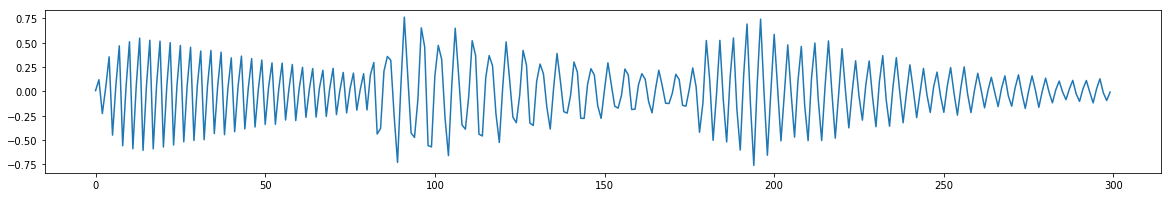

In [3]:
# notes with onset and decay
note1_start = 0
note2_start = 80
note3_start = 175

signal1 = [0.7 * np.arctan(x/5) * np.exp(-x/50) * np.sin(2*np.pi*(x)/3.0 + 0.1) for x in np.arange(0,300-note1_start)]
signal2 = [0.7 * np.arctan(x/5) * np.exp(-x/50) * np.sin(2*np.pi*(x)/5.0 + 0.1) for x in np.arange(0,300-note2_start)]
signal3 = [0.7 * np.arctan(x/5) * np.exp(-x/50) * np.sin(2*np.pi*(x)/4.0 + 0.1) for x in np.arange(0,300-note3_start)]

signal = np.zeros(300)
signal[note1_start:300] += signal1
signal[note2_start:300] += signal2
signal[note3_start:300] += signal3

signal += 0.01*np.random.randn(300)  # add noise

plt.figure(figsize=(20,3))
plt.plot(signal)
plt.show()

In [4]:
nll2 = np.zeros(300-7)  # initialise list of nll2nents
nll2_t_ = np.zeros(300-7)  # initialise list of nll2nents
nll2_p = np.zeros(300-7)  # initialise list of nll2nents

In [5]:
P = [3,4,5,6,7,8]  # list of periods

Pre-calculation with 
$$
C(n,p) = \sum_{k=1}^{n} s(k)s(k+p)
$$

In [6]:
cee_time_plot_start = 0 # try 0
cee_time_plot_end = len(signal)-6 # try 3000
cee_time_plot_range = cee_time_plot_end - cee_time_plot_start
cee_period_plot_start = 3 # try 0
cee_period_plot_end = 6 # try 300
cee_period_plot_range = cee_period_plot_end - cee_period_plot_start

X = np.arange(cee_time_plot_start, cee_time_plot_end, 1)
Y = np.arange(cee_period_plot_start, cee_period_plot_end, 1)

cee = np.zeros((cee_time_plot_range, cee_period_plot_range))

# for t in range(signal_length):
for p in range(cee_period_plot_start, cee_period_plot_end):
    p_ = p - cee_period_plot_start  # array index is not actual period length
    # cumsum so that you do not need to calculate everything again and again
    # what is the difference between two square brackets and a comma in a square bracket?
    cee[:,p_] = np.cumsum(np.multiply(signal[:cee_time_plot_end],
                                     signal[p:cee_time_plot_end+p]))

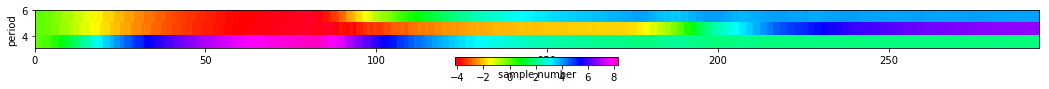

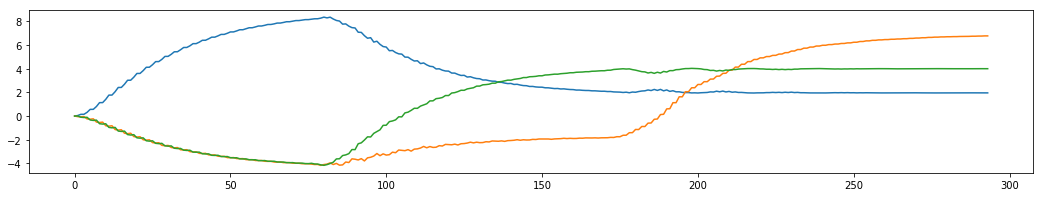

In [7]:
import matplotlib.cm as cm
import matplotlib.colors as colors
cee_ = np.transpose(cee)
cee_ = np.flip(cee_, 0)

plt.figure(figsize=(18,1))
img = plt.imshow(cee_, cmap=cm.gist_rainbow, aspect='auto', 
                 extent=[cee_time_plot_start, 
                         cee_time_plot_end, 
                         cee_period_plot_start, 
                         cee_period_plot_end], 
                )
plt.xlabel("sample number")
plt.ylabel("period")
plt.colorbar(orientation="horizontal")
plt.show()

plt.figure(figsize=(18,3))
plt.plot(cee)
plt.show()

In [18]:
# def lel(t_,t,P):
#     new_note_penalty = 1
#     logexp_list_vary_p = []
# #     p_list = []
    
#     for p in P:
#         p = p-np.min(P)
#         if t_ + p < t:
#             logexp_list_vary_p.append(cee[t_,p] - cee[t,p])
# #             p_list.append(p+3) # ERROR
#     arg_min = np.argmin(logexp_list_vary_p)
#     return logexp_list_vary_p[arg_min] + new_note_penalty, P[arg_min]

# p_list is actually P
# logexp, nll2 -> nll2

In [74]:
# maximise over p
def lel(t_,t,P):
#     print("\n{}~{}:".format(t_, t), end='')
    new_note_penalty = 2.5
    logexp_list_vary_p = []
    p_list = []
    
    for p in P:
        if t_ + p < t:
            to_append = np.sum([(signal[k+p] - signal[k])**2 for k in range(t_,t-p)])
#             print(" p{}-{:.3f}  ".format(p,to_append), end='')
            logexp_list_vary_p.append(to_append)
            p_list.append(p)
    arg_max = np.argmin(logexp_list_vary_p)
    return logexp_list_vary_p[arg_max] + new_note_penalty, p_list[arg_max] 

In [75]:
# minimise over t_

for i in range(4,300-7):
# for i in range(4,10):
    print("exp[{}]".format(i), end='')
    
    logexp_list_vary_t_ = []
    t__list = []
    p_min_list = []
    
    for t_ in range(i-np.min(P)):
        value, p_min = lel(t_,i,P)
        logexp_list_vary_t_.append(value)
        t__list.append(t_)
        p_min_list.append(p_min)
        
    arg_min = np.argmin(np.add(nll2[:len(logexp_list_vary_t_)], logexp_list_vary_t_))
    
    nll2[i] = nll2[arg_min] + logexp_list_vary_t_[arg_min]
    
    nll2_p[i] = p_min_list[arg_min]
    nll2_t_[i] = t__list[arg_min]
    print("\nminimum = {:5f} at t'={} and p={} \n".format(nll2[i], nll2_t_[i], nll2_p[i]))

exp[4]
minimum = 2.501139 at t'=0.0 and p=3.0 

exp[5]
minimum = 2.555046 at t'=1.0 and p=3.0 

exp[6]
minimum = 2.548977 at t'=2.0 and p=3.0 

exp[7]
minimum = 2.500585 at t'=3.0 and p=3.0 

exp[8]
minimum = 2.513378 at t'=3.0 and p=3.0 

exp[9]
minimum = 2.525178 at t'=3.0 and p=3.0 

exp[10]
minimum = 2.500173 at t'=3.0 and p=6.0 

exp[11]
minimum = 2.524036 at t'=3.0 and p=6.0 

exp[12]
minimum = 2.527961 at t'=3.0 and p=3.0 

exp[13]
minimum = 2.528006 at t'=3.0 and p=3.0 

exp[14]
minimum = 2.529393 at t'=3.0 and p=3.0 

exp[15]
minimum = 2.529674 at t'=3.0 and p=3.0 

exp[16]
minimum = 2.529712 at t'=3.0 and p=3.0 

exp[17]
minimum = 2.530201 at t'=3.0 and p=3.0 

exp[18]
minimum = 2.530446 at t'=3.0 and p=3.0 

exp[19]
minimum = 2.530681 at t'=3.0 and p=3.0 

exp[20]
minimum = 2.530760 at t'=3.0 and p=3.0 

exp[21]
minimum = 2.531118 at t'=3.0 and p=3.0 

exp[22]
minimum = 2.531393 at t'=3.0 and p=3.0 

exp[23]
minimum = 2.531630 at t'=3.0 and p=3.0 

exp[24]
minimum = 2.532048

exp[172]
minimum = 6.625970 at t'=82.0 and p=5.0 

exp[173]
minimum = 6.629824 at t'=82.0 and p=5.0 

exp[174]
minimum = 6.630313 at t'=82.0 and p=5.0 

exp[175]
minimum = 6.631013 at t'=82.0 and p=5.0 

exp[176]
minimum = 6.632815 at t'=82.0 and p=5.0 

exp[177]
minimum = 6.637086 at t'=82.0 and p=5.0 

exp[178]
minimum = 6.642946 at t'=82.0 and p=5.0 

exp[179]
minimum = 6.718820 at t'=82.0 and p=5.0 

exp[180]
minimum = 6.719847 at t'=82.0 and p=5.0 

exp[181]
minimum = 6.965565 at t'=82.0 and p=5.0 

exp[182]
minimum = 6.980912 at t'=82.0 and p=5.0 

exp[183]
minimum = 7.280397 at t'=82.0 and p=5.0 

exp[184]
minimum = 7.429516 at t'=82.0 and p=5.0 

exp[185]
minimum = 7.841632 at t'=82.0 and p=5.0 

exp[186]
minimum = 8.210763 at t'=82.0 and p=5.0 

exp[187]
minimum = 8.613889 at t'=82.0 and p=5.0 

exp[188]
minimum = 9.022083 at t'=82.0 and p=5.0 

exp[189]
minimum = 9.219359 at t'=178.0 and p=8.0 

exp[190]
minimum = 9.235886 at t'=177.0 and p=4.0 

exp[191]
minimum = 9.242810 a

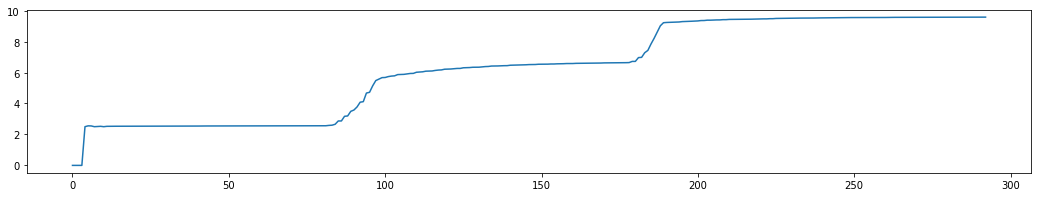

In [76]:
plt.figure(figsize=(18,3))
plt.plot(nll2)
plt.show()

In [77]:
# plot s(t) (DONE)
# plot t_ locations (DONE)
# plot periods
# start of note locations (DONE)
# graph against different penalty terms
# visualise e(t)?? (???)
# change the noise, overlap?
# how about non-integer notes???
# build the traceback algorithm (DONE)

In [78]:
# plt.figure(figsize=(18,3))
# plt.plot(nll2)
# # plt.plot(nll2_p)
# plt.plot(np.arange(300-7)-nll2_t_)
# plt.plot(nll2_p)  # t_ is when the current note have started
# plt.show()

In [79]:
# traceback algorithm
t_list = []
p_list = []

k = int(len(nll2_t_) - 1)

while True:
    t_list.append(k)
    p_list.append(nll2_p[k])
    i = nll2_t_[k]
    k = int(i)
    if i == 0:
        t_list.append(k)
        break

t_list = t_list[::-1]
p_list = p_list[::-1]
print(t_list)
print(p_list)

[0, 3, 82, 177, 292]
[0.0, 3.0, 5.0, 4.0]


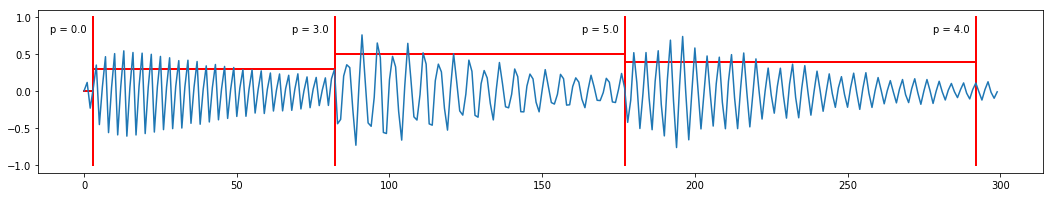

In [80]:
plt.figure(figsize=(18,3))
for k in range(len(p_list)):
    plt.plot([t_list[k+1], t_list[k+1]], [-1, 1], color='r', linestyle='-', linewidth=2)
    plt.plot([t_list[k], t_list[k+1]], [0.1*p_list[k], 0.1*p_list[k]], color='r', linestyle='-', linewidth=2)
    plt.text(t_list[k+1], 0.8, "p = {}  ".format(p_list[k]), horizontalalignment='right')
plt.plot(signal)
plt.show()